## Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import spacetrack.operators as op
from spacetrack import SpaceTrackClient
import datetime as dt
import pandas as pd
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.dates as mdates
import sklearn
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
import lazypredict.Supervised
from lazypredict.Supervised import LazyRegressor
from tqdm import tqdm

In [2]:
st = SpaceTrackClient(identity="wkline@mit.edu", password="C4ABwn*mt1tl1zp")

In [3]:
mu_in_km_one_third = 3.986e5 ** (1/3)
tle_epoch = datetime(2000, 1, 1)

In [4]:
def parse_sci_notation(num):
  if num.startswith('-'):
    parts = num[1:].split('-')
    parts.insert(0, "-" + parts.pop(0))
  else:
    parts = num.split('-')
  return int(parts[0]) * 10 ** (-1 * int(parts[1]))

def parse_tle(tle_data):
    lines = tle_data.split('\n')
    num_obs = int(len(lines) / 2)
    cat_nums = np.zeros(num_obs, dtype = int)
    classifications = np.zeros(num_obs, dtype = str)
    launch_years = np.zeros(num_obs, dtype = int)
    launch_nums = np.zeros(num_obs, dtype = int)
    launch_pieces = np.zeros(num_obs, dtype = str)
    epoch_years = np.zeros(num_obs, dtype = int)
    epoch_days = np.zeros(num_obs, dtype = float)
    ballistic_coefs = np.zeros(num_obs, dtype = float)
    deriv_ballistic_coefs = np.zeros(num_obs, dtype = float)
    drag_terms = np.zeros(num_obs, dtype = float)
    elset_nums = np.zeros(num_obs, dtype = int)

    inclinations = np.zeros(num_obs, dtype = float)
    RAANs = np.zeros(num_obs, dtype = float)
    eccentricities = np.zeros(num_obs, dtype = float)
    perigee_args = np.zeros(num_obs, dtype = float)
    mean_anomalies = np.zeros(num_obs, dtype = float)
    mean_motions = np.zeros(num_obs, dtype = float)
    rev_numbers = np.zeros(num_obs, dtype = int)

    for i in range(0, len(lines), 2):
      if lines[i] != '':
        #Format: lines[line-1][firstcol-1:lastcol]
        cat_num = int(lines[i][2:7])
        classification = lines[i][7:8]
        launch_year = int(lines[i][9:11])
        launch_num = int(lines[i][11:14])
        launch_piece = lines[i][14:17]
        epoch_year = int(lines[i][18:20])
        epoch_day = float(lines[i][20:32])
        ballistic_coef = float(lines[i][33:43])
        deriv_ballistic_coef = parse_sci_notation(lines[i][44:52]) * float(10 ** -5)
        drag_term = parse_sci_notation(lines[i][53:61]) * float(10 ** -5)
        elset_num = int(lines[i][64:68])

        inclination = float(lines[i+1][8:16])
        RAAN = float(lines[i+1][17:25])
        eccentricity = float(lines[i+1][26:33]) * 10 ** -7
        perigee_arg = float(lines[i+1][34:42])
        mean_anomaly = float(lines[i+1][43:51])
        mean_motion = float(lines[i+1][52:63])
        rev_number = int(lines[i+1][63:68])

        # Putting the extracted values into lists
        cat_nums[int(i/2)] = cat_num
        classifications[int(i/2)] = classification
        launch_years[int(i/2)] = launch_year
        launch_nums[int(i/2)] = launch_num
        launch_pieces[int(i/2)] = launch_piece
        epoch_years[int(i/2)] = epoch_year
        epoch_days[int(i/2)] = epoch_day
        ballistic_coefs[int(i/2)] = ballistic_coef
        deriv_ballistic_coefs[int(i/2)] = deriv_ballistic_coef
        drag_terms[int(i/2)] = drag_term
        elset_nums[int(i/2)] = elset_num

        inclinations[int(i/2)] = inclination
        RAANs[int(i/2)] = RAAN
        eccentricities[int(i/2)] = eccentricity
        perigee_args[int(i/2)] = perigee_arg
        mean_anomalies[int(i/2)] = mean_anomaly
        mean_motions[int(i/2)] = mean_motion
        rev_numbers[int(i/2)] = rev_number

    return (cat_nums, classifications, launch_years, launch_pieces, epoch_years, epoch_days, 
            ballistic_coefs, deriv_ballistic_coefs, drag_terms, elset_nums, inclinations,
            RAANs, eccentricities, perigee_args, mean_anomalies, mean_motions, rev_numbers)

def parse_mean_motion_only(tle_data):
  cat_nums, classifications, launch_years, launch_pieces, epoch_years, epoch_days, ballistic_coefs, deriv_ballistic_coefs, drag_terms, elset_nums, inclinations, RAANs, eccentricities, perigee_args, mean_anomalies, mean_motions, rev_numbers = parse_tle(tle_data)
  #total_epoch_metrics = (epoch_years - 21.49) * 365 + epoch_days
  datelist = []
  for i in range(len(epoch_years)):
    datelist.append(convert_years_days_to_date(tle_epoch, epoch_years[i], epoch_days[i]))
  return datelist, mean_motions

def convert_years_days_to_date(start_date, years, days):
    # Add the years
    final_date = start_date + relativedelta(years=int(years))
    
    # Add the days, including the fractional part
    days_fraction = (years - int(years)) * 365.25 + days  # approximate leap year handling
    final_date += timedelta(days=days_fraction)
    
    return final_date

def give_coe_from_tle(tle_data):
    cat_nums, classifications, launch_years, launch_pieces, epoch_years, epoch_days, ballistic_coefs, deriv_ballistic_coefs, drag_terms, elset_nums, inclinations, RAANs, eccentricities, perigee_args, mean_anomalies, mean_motions, rev_numbers = parse_tle(tle_data)
    datelist = []
    for i in range(len(epoch_years)):
      datelist.append(convert_years_days_to_date(tle_epoch, epoch_years[i], epoch_days[i]))
    mean_alts = mu_in_km_one_third / ((2 * mean_motions * np.pi / 86400) ** (2/3)) - 6371
    cat_nums = [ int(x) for x in cat_nums ]
    return datelist, cat_nums, ballistic_coefs, eccentricities, mean_motions, mean_alts, inclinations, RAANs, perigee_args, mean_anomalies

## Load OMNIWeb Data

In [5]:
# 1. Define file path and time range
agg_file = "data/omniweb_data/merged_omni_indices.csv"

start_time_str = "2007-04-03 05:00:00"
end_time_str = "2024-12-29 05:00:00"
datetime_format = "%Y-%m-%d %H:%M:%S"
start_time = datetime.strptime(start_time_str, datetime_format)
end_time = datetime.strptime(end_time_str, datetime_format)

# 2. Define the desired columns
desired_columns = [
    "all__dates_datetime__",
    "omniweb__ae_index__[nT]",
    "omniweb__al_index__[nT]",
    "omniweb__au_index__[nT]",
    "omniweb__sym_d__[nT]",
    "omniweb__sym_h__[nT]",
    "omniweb__asy_d__[nT]"
]

# 3. Read the aggregated CSV and filter rows and columns
df_omniweb = pd.read_csv(agg_file, parse_dates=["all__dates_datetime__"])
df_omniweb = df_omniweb[desired_columns]
df_omniweb = df_omniweb[(df_omniweb["all__dates_datetime__"] >= start_time) & (df_omniweb["all__dates_datetime__"] <= end_time)]

# 4. Display the final DataFrame
df_omniweb

,all__dates_datetime__,omniweb__ae_index__[nT],omniweb__al_index__[nT],omniweb__au_index__[nT],omniweb__sym_d__[nT],omniweb__sym_h__[nT],omniweb__asy_d__[nT]
3814860,2007-04-03 05:00:00,168.00,-95.00,73.00,-1,-29,15
3814861,2007-04-03 05:01:00,173.00,-100.00,73.00,-1,-29,15
3814862,2007-04-03 05:02:00,195.00,-120.00,75.00,-1,-29,15
3814863,2007-04-03 05:03:00,210.00,-133.00,77.00,-1,-29,15
3814864,2007-04-03 05:04:00,197.00,-125.00,72.00,-1,-29,15
...,...,...,...,...,...,...,...
12841915,2024-05-31 23:55:00,54.00,-43.00,11.00,3,-28,41
12841916,2024-05-31 23:56:00,54.00,-43.00,11.00,3,-28,41
12841917,2024-05-31 23:57:00,54.00,-43.00,11.00,3,-28,41
12841918,2024-05-31 23:58:00,54.00,-43.00,11.00,3,-28,41


## Load GOES Data

In [6]:
# 1. Define file path and time range
agg_file = "goes_aggregated_arclab.csv"
start_time_str = "2004-04-03 05:00:00"
end_time_str   = "2024-12-29 05:00:00"
datetime_format = "%Y-%m-%d %H:%M:%S"
start_time = datetime.strptime(start_time_str, datetime_format)
end_time   = datetime.strptime(end_time_str, datetime_format)

# 2. Define the columns to keep
columns_to_keep = [
    "Timestamp",
    "xrsa_flux",
    "xrsa_flux_observed",
    "xrsa_flux_electrons",
    "xrsb_flux",
    "xrsb_flux_observed",
    "xrsb_flux_electrons"
]

# 3. Read the aggregated CSV, filter by time, and select desired columns
df_goes = pd.read_csv(agg_file, parse_dates=["Timestamp"])
df_goes = df_goes[(df_goes["Timestamp"] >= start_time) & (df_goes["Timestamp"] <= end_time)]
df_goes = df_goes[columns_to_keep]

# 4. Display the final DataFrame
df_goes

,Timestamp,xrsa_flux,xrsa_flux_observed,xrsa_flux_electrons,xrsb_flux,xrsb_flux_observed,xrsb_flux_electrons
33378,2004-04-03 06:00:00,0.00,NaN,NaN,0.00,NaN,NaN
33379,2004-04-03 07:00:00,0.00,NaN,NaN,0.00,NaN,NaN
33380,2004-04-03 08:00:00,0.00,NaN,NaN,0.00,NaN,NaN
33381,2004-04-03 09:00:00,0.00,NaN,NaN,0.00,NaN,NaN
33382,2004-04-03 10:00:00,0.00,NaN,NaN,0.00,NaN,NaN
...,...,...,...,...,...,...,...
106721,2020-12-30 07:00:00,0.00,0.00,0.00,0.00,0.00,0.00
106722,2020-12-30 08:00:00,0.00,0.00,0.00,0.00,0.00,0.00
106723,2020-12-30 09:00:00,0.00,0.00,0.00,0.00,0.00,0.00
106724,2020-12-30 10:00:00,0.00,0.00,0.00,0.00,0.00,0.00


## Kanopus-V3 Example

In [7]:
sat_nums = [43180]

drange = op.inclusive_range(dt.datetime(2024, 5, 8), dt.datetime(2024, 5, 17))

columns = [
    "time_data", "eccentricities", "mean_motions",
    "mean_alts", "inclinations", "RAANs", "perigee_args", "mean_anomalies",
    "deriv_alt_wrt_days"
]
df0 = pd.DataFrame(columns=columns)
rows_to_add = []

for sat in sat_nums:
  data = st.tle(norad_cat_id = sat, epoch=drange, orderby='epoch', format='tle')
  time_data, cat_id, ballistic_coefs, eccentricities, mean_motions, mean_alts, inclinations, RAANs, perigee_args, mean_anomalies = give_coe_from_tle(data)

  deriv_alt_wrt_days = [None, None]
  for i in range(2, len(mean_alts) - 2):
    alt_before = (mean_alts[i-2] + mean_alts[i-1]) / 2
    alt_after = (mean_alts[i+1] + mean_alts[i+2]) / 2
    altitude_change = alt_after - alt_before
    time_diff_inner = (time_data[i+1] - time_data[i-1]).total_seconds() / (24*3600)
    time_diff_outer = (time_data[i+2] - time_data[i-2]).total_seconds() / (24*3600)
    time_diff_days = (time_diff_inner + time_diff_outer) / 2

    if altitude_change < 0:
      deriv_alt_wrt_days.append(altitude_change/time_diff_days)
    else:
      deriv_alt_wrt_days.append(None)

  deriv_alt_wrt_days.append(None)
  deriv_alt_wrt_days.append(None)

  for i in range(len(time_data)):
    row = {
          "time_data": time_data[i],
          "cat_id": cat_id[i],
          "ballistic_coefs": ballistic_coefs[i],
          "eccentricities": eccentricities[i],
          "mean_motions": mean_motions[i],
          "mean_alts": mean_alts[i],
          "inclinations": inclinations[i],
          "RAANs": RAANs[i],
          "perigee_args": perigee_args[i],
          "mean_anomalies": mean_anomalies[i],
          "deriv_alt_wrt_days": deriv_alt_wrt_days[i]
      }
    rows_to_add.append(row)

df0 = pd.concat([df0, pd.DataFrame(rows_to_add)], ignore_index=True)

# Sort the DataFrame by 'cat_id' and 'time_data'
df0 = df0.sort_values('time_data', ascending=True)

# Create a shifted column of time_data by 1 day
df0['shifted_time'] = df0['time_data'] - pd.Timedelta(days=1)

# Use merge_asof within each group of cat_id
df0 = pd.merge_asof(
    df0,
    df0[['cat_id', 'time_data', 'mean_alts']].rename(columns={'time_data': 'shifted_time'}),
    left_on='shifted_time',
    right_on='shifted_time',
    direction='backward',
    by='cat_id',  # Ensures the merge is done within each cat_id group
    suffixes=('', '_1day_ago')
)

df0 = pd.merge_asof(
    df0,
    df0[['cat_id', 'time_data', 'ballistic_coefs']].rename(columns={'time_data': 'shifted_time'}),
    left_on='shifted_time',
    right_on='shifted_time',
    direction='backward',
    by='cat_id',  # Ensures the merge is done within each cat_id group
    suffixes=('', '_1day_ago')
)

# Rename the resulting columns
df0.rename(columns={'mean_alts_1day_ago': 'alt_1day_lag'}, inplace=True)
df0.rename(columns={'ballistic_coefs_1day_ago': 'bc_1day_lag'}, inplace=True)

# Drop the helper column
df0.drop(columns=['shifted_time'], inplace=True)

df0 = df0.sort_values('time_data', ascending=True)

df0

,time_data,eccentricities,mean_motions,mean_alts,inclinations,RAANs,perigee_args,mean_anomalies,deriv_alt_wrt_days,cat_id,ballistic_coefs,alt_1day_lag,bc_1day_lag
0,2024-05-09 05:04:34.717152,0.00,15.22,505.98,97.40,37.58,94.48,265.67,NaN,43180.00,0.00,NaN,NaN
1,2024-05-09 12:57:50.612832,0.00,15.22,505.97,97.40,37.91,94.88,265.26,NaN,43180.00,0.00,NaN,NaN
2,2024-05-09 14:32:29.789376,0.00,15.22,505.97,97.40,37.97,95.07,265.08,-0.03,43180.00,0.00,NaN,NaN
3,2024-05-09 19:16:27.286176,0.00,15.22,505.96,97.40,38.17,95.24,264.90,-0.03,43180.00,0.00,NaN,NaN
4,2024-05-09 22:25:45.626304,0.00,15.22,505.96,97.40,38.30,95.20,264.95,-0.03,43180.00,0.00,NaN,NaN
5,2024-05-10 04:44:22.272864,0.00,15.22,505.95,97.40,38.55,94.79,265.35,-0.03,43180.00,0.00,NaN,NaN
6,2024-05-10 12:37:37.992288,0.00,15.22,505.94,97.40,38.88,94.67,265.48,-0.04,43180.00,0.00,505.98,0.00
7,2024-05-10 14:12:17.133408,0.00,15.22,505.94,97.40,38.94,94.87,265.28,-0.04,43180.00,0.00,505.97,0.00
8,2024-05-10 18:56:14.543808,0.00,15.22,505.93,97.40,39.14,94.99,265.15,-0.04,43180.00,0.00,505.97,0.00
9,2024-05-10 22:05:32.808768,0.00,15.22,505.93,97.40,39.27,94.99,265.16,-0.03,43180.00,0.00,505.96,0.00


In [8]:
kanopus = pd.merge_asof(df0, df_omniweb, left_on='time_data', right_on='all__dates_datetime__', direction='nearest')
kanopus = pd.merge_asof(kanopus, df_goes, left_on='time_data', right_on='Timestamp', direction='nearest')

kanopus

,time_data,eccentricities,mean_motions,mean_alts,inclinations,RAANs,perigee_args,mean_anomalies,deriv_alt_wrt_days,cat_id,...,omniweb__sym_d__[nT],omniweb__sym_h__[nT],omniweb__asy_d__[nT],Timestamp,xrsa_flux,xrsa_flux_observed,xrsa_flux_electrons,xrsb_flux,xrsb_flux_observed,xrsb_flux_electrons
0,2024-05-09 05:04:34.717152,0.00,15.22,505.98,97.40,37.58,94.48,265.67,NaN,43180.00,...,5,-1,42,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
1,2024-05-09 12:57:50.612832,0.00,15.22,505.97,97.40,37.91,94.88,265.26,NaN,43180.00,...,2,4,10,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
2,2024-05-09 14:32:29.789376,0.00,15.22,505.97,97.40,37.97,95.07,265.08,-0.03,43180.00,...,2,6,13,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
3,2024-05-09 19:16:27.286176,0.00,15.22,505.96,97.40,38.17,95.24,264.90,-0.03,43180.00,...,-3,9,18,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
4,2024-05-09 22:25:45.626304,0.00,15.22,505.96,97.40,38.30,95.20,264.95,-0.03,43180.00,...,0,12,19,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
5,2024-05-10 04:44:22.272864,0.00,15.22,505.95,97.40,38.55,94.79,265.35,-0.03,43180.00,...,2,2,47,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
6,2024-05-10 12:37:37.992288,0.00,15.22,505.94,97.40,38.88,94.67,265.48,-0.04,43180.00,...,0,-9,34,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
7,2024-05-10 14:12:17.133408,0.00,15.22,505.94,97.40,38.94,94.87,265.28,-0.04,43180.00,...,5,4,20,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
8,2024-05-10 18:56:14.543808,0.00,15.22,505.93,97.40,39.14,94.99,265.15,-0.04,43180.00,...,17,-92,247,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
9,2024-05-10 22:05:32.808768,0.00,15.22,505.93,97.40,39.27,94.99,265.16,-0.03,43180.00,...,-13,-231,185,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00


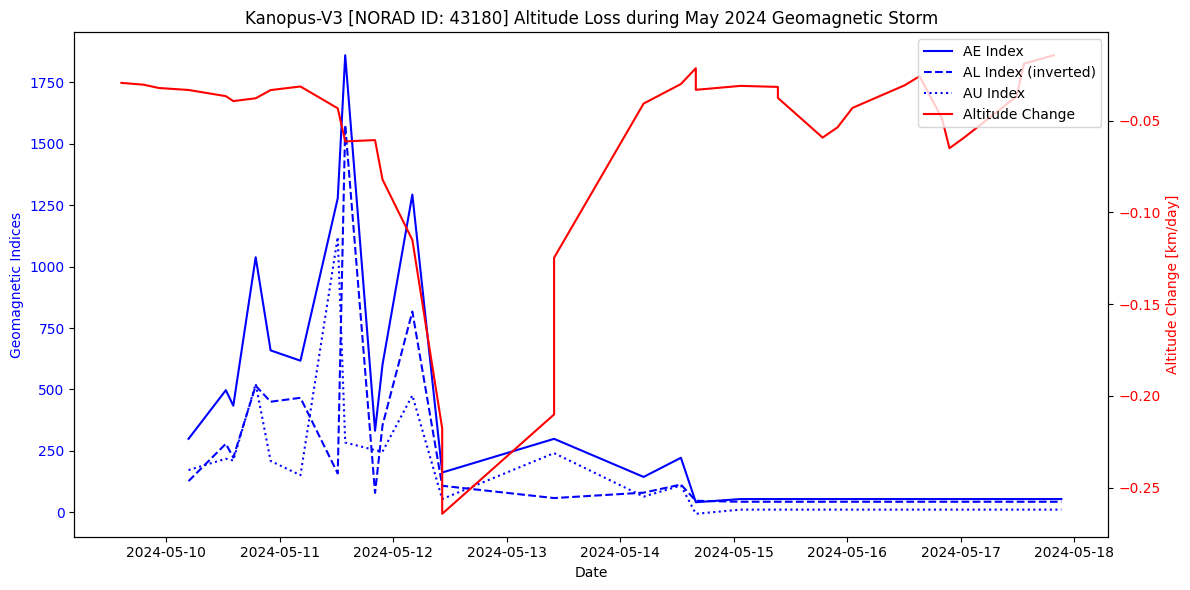

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 6))

line1, = ax1.plot(kanopus['time_data'], kanopus['omniweb__ae_index__[nT]'], label="AE Index", color="blue", linestyle='-')
line2, = ax1.plot(kanopus['time_data'], -kanopus['omniweb__al_index__[nT]'], label="AL Index (inverted)", color="blue", linestyle='--')
line3, = ax1.plot(kanopus['time_data'], kanopus['omniweb__au_index__[nT]'], label="AU Index", color="blue", linestyle=':')
ax1.set_xlabel("Date")
ax1.set_ylabel("Geomagnetic Indices", color = 'blue')
ax1.tick_params(axis='y', labelcolor="blue")
ax1.set_title('Kanopus-V3 [NORAD ID: 43180] Altitude Loss during May 2024 Geomagnetic Storm')

ax2 = ax1.twinx()
line4, = ax2.plot(kanopus['time_data'], kanopus['deriv_alt_wrt_days'], label="Altitude Change", color="red", linestyle='-')
ax2.set_ylabel("Altitude Change [km/day]", color = 'red')
ax2.tick_params(axis='y', labelcolor="red")

lines = [line1, line2, line3, line4]
labels = [line.get_label() for line in lines]
fig.legend(lines, labels, loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes)

plt.tight_layout()
plt.show()

## Training Data

In [10]:
sat_nums = [26386, 27942, 28098]

drange = op.inclusive_range(dt.datetime(2004, 11, 1), dt.datetime(2005, 3, 31))

columns = [
    "time_data", "eccentricities", "mean_motions",
    "mean_alts", "inclinations", "RAANs", "perigee_args", "mean_anomalies",
    "deriv_alt_wrt_days"
]
df2 = pd.DataFrame(columns=columns)
rows_to_add = []

for sat in sat_nums:
  data = st.tle(norad_cat_id = sat, epoch=drange, orderby='epoch', format='tle')
  time_data, cat_id, ballistic_coefs, eccentricities, mean_motions, mean_alts, inclinations, RAANs, perigee_args, mean_anomalies = give_coe_from_tle(data)

  deriv_alt_wrt_days = [None, None]
  for i in range(2, len(mean_alts) - 2):
    alt_before = (mean_alts[i-2] + mean_alts[i-1]) / 2
    alt_after = (mean_alts[i+1] + mean_alts[i+2]) / 2
    altitude_change = alt_after - alt_before
    time_diff_inner = (time_data[i+1] - time_data[i-1]).total_seconds() / (24*3600)
    time_diff_outer = (time_data[i+2] - time_data[i-2]).total_seconds() / (24*3600)
    time_diff_days = (time_diff_inner + time_diff_outer) / 2

    if altitude_change < 0:
      deriv_alt_wrt_days.append(altitude_change/time_diff_days)
    else:
      deriv_alt_wrt_days.append(None)

  deriv_alt_wrt_days.append(None)
  deriv_alt_wrt_days.append(None)

  for i in range(len(time_data)):
    row = {
          "time_data": time_data[i],
          "cat_id": cat_id[i],
          "ballistic_coefs": ballistic_coefs[i],
          "eccentricities": eccentricities[i],
          "mean_motions": mean_motions[i],
          "mean_alts": mean_alts[i],
          "inclinations": inclinations[i],
          "RAANs": RAANs[i],
          "perigee_args": perigee_args[i],
          "mean_anomalies": mean_anomalies[i],
          "deriv_alt_wrt_days": deriv_alt_wrt_days[i]
      }
    rows_to_add.append(row)

df2 = pd.concat([df2, pd.DataFrame(rows_to_add)], ignore_index=True)

# Sort the DataFrame by 'cat_id' and 'time_data'
df2 = df2.sort_values('time_data', ascending=True)

# Create a shifted column of time_data by 1 day
df2['shifted_time'] = df2['time_data'] - pd.Timedelta(days=1)

# Use merge_asof within each group of cat_id
df2 = pd.merge_asof(
    df2,
    df2[['cat_id', 'time_data', 'mean_alts']].rename(columns={'time_data': 'shifted_time'}),
    left_on='shifted_time',
    right_on='shifted_time',
    direction='backward',
    by='cat_id',  # Ensures the merge is done within each cat_id group
    suffixes=('', '_1day_ago')
)

df2 = pd.merge_asof(
    df2,
    df2[['cat_id', 'time_data', 'ballistic_coefs']].rename(columns={'time_data': 'shifted_time'}),
    left_on='shifted_time',
    right_on='shifted_time',
    direction='backward',
    by='cat_id',  # Ensures the merge is done within each cat_id group
    suffixes=('', '_1day_ago')
)

# Rename the resulting columns
df2.rename(columns={'mean_alts_1day_ago': 'alt_1day_lag'}, inplace=True)
df2.rename(columns={'ballistic_coefs_1day_ago': 'bc_1day_lag'}, inplace=True)

# Drop the helper column
df2.drop(columns=['shifted_time'], inplace=True)

df2 = df2.sort_values('time_data', ascending=True)

df2

,time_data,eccentricities,mean_motions,mean_alts,inclinations,RAANs,perigee_args,mean_anomalies,deriv_alt_wrt_days,cat_id,ballistic_coefs,alt_1day_lag,bc_1day_lag
0,2004-11-02 08:47:22.402464,0.00,15.38,459.63,67.08,271.00,217.16,142.88,NaN,28098.00,0.00,NaN,NaN
1,2004-11-02 09:21:01.977408,0.00,14.63,691.85,98.16,194.11,56.76,303.48,NaN,27942.00,0.00,NaN,NaN
2,2004-11-02 10:06:17.273664,0.00,14.64,685.93,98.34,275.79,73.04,287.22,NaN,26386.00,0.00,NaN,NaN
3,2004-11-02 12:38:03.424992,0.00,14.63,691.85,98.16,194.25,56.33,303.91,NaN,27942.00,0.00,NaN,NaN
4,2004-11-02 16:39:50.327136,0.00,14.64,685.93,98.34,276.07,71.91,288.35,NaN,26386.00,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2005-03-31 16:51:25.308864,0.00,14.65,685.46,98.36,67.25,328.48,31.57,NaN,26386.00,0.00,685.47,0.00
1004,2005-03-31 18:43:13.128384,0.00,15.39,457.27,67.08,174.82,337.52,22.57,NaN,28098.00,0.00,457.28,0.00
1005,2005-03-31 18:43:13.128384,0.00,15.39,457.27,67.08,174.82,337.52,22.57,NaN,28098.00,0.00,457.28,0.00
1006,2005-03-31 20:42:56.212704,0.00,14.63,691.58,98.14,341.69,313.15,46.88,NaN,27942.00,0.00,691.58,0.00


In [11]:
training_data = pd.merge_asof(df2, df_omniweb, left_on='time_data', right_on='all__dates_datetime__', direction='nearest')
training_data = pd.merge_asof(training_data, df_goes, left_on='time_data', right_on='Timestamp', direction='nearest')

training_data

,time_data,eccentricities,mean_motions,mean_alts,inclinations,RAANs,perigee_args,mean_anomalies,deriv_alt_wrt_days,cat_id,...,omniweb__sym_d__[nT],omniweb__sym_h__[nT],omniweb__asy_d__[nT],Timestamp,xrsa_flux,xrsa_flux_observed,xrsa_flux_electrons,xrsb_flux,xrsb_flux_observed,xrsb_flux_electrons
0,2004-11-02 08:47:22.402464,0.00,15.38,459.63,67.08,271.00,217.16,142.88,NaN,28098.00,...,-1,-29,15,2004-11-02 09:00:00,0.00,NaN,NaN,0.00,NaN,NaN
1,2004-11-02 09:21:01.977408,0.00,14.63,691.85,98.16,194.11,56.76,303.48,NaN,27942.00,...,-1,-29,15,2004-11-02 09:00:00,0.00,NaN,NaN,0.00,NaN,NaN
2,2004-11-02 10:06:17.273664,0.00,14.64,685.93,98.34,275.79,73.04,287.22,NaN,26386.00,...,-1,-29,15,2004-11-02 10:00:00,0.00,NaN,NaN,0.00,NaN,NaN
3,2004-11-02 12:38:03.424992,0.00,14.63,691.85,98.16,194.25,56.33,303.91,NaN,27942.00,...,-1,-29,15,2004-11-02 13:00:00,0.00,NaN,NaN,0.00,NaN,NaN
4,2004-11-02 16:39:50.327136,0.00,14.64,685.93,98.34,276.07,71.91,288.35,NaN,26386.00,...,-1,-29,15,2004-11-02 17:00:00,0.00,NaN,NaN,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1003,2005-03-31 16:51:25.308864,0.00,14.65,685.46,98.36,67.25,328.48,31.57,NaN,26386.00,...,-1,-29,15,2005-03-31 17:00:00,0.00,NaN,NaN,0.00,NaN,NaN
1004,2005-03-31 18:43:13.128384,0.00,15.39,457.27,67.08,174.82,337.52,22.57,NaN,28098.00,...,-1,-29,15,2005-03-31 19:00:00,0.00,NaN,NaN,0.00,NaN,NaN
1005,2005-03-31 18:43:13.128384,0.00,15.39,457.27,67.08,174.82,337.52,22.57,NaN,28098.00,...,-1,-29,15,2005-03-31 19:00:00,0.00,NaN,NaN,0.00,NaN,NaN
1006,2005-03-31 20:42:56.212704,0.00,14.63,691.58,98.14,341.69,313.15,46.88,NaN,27942.00,...,-1,-29,15,2005-03-31 21:00:00,0.00,NaN,NaN,0.00,NaN,NaN


## Testing Data

In [12]:
sat_nums = [58472]
drange = op.inclusive_range(dt.datetime(2024, 3, 1), dt.datetime(2024, 7, 31))

columns = [
    "time_data", "eccentricities", "mean_motions",
    "mean_alts", "inclinations", "RAANs", "perigee_args", "mean_anomalies",
    "deriv_alt_wrt_days"
]
df4 = pd.DataFrame(columns=columns)
rows_to_add = []

for sat in sat_nums:
  data = st.tle(norad_cat_id = sat, epoch=drange, orderby='epoch', format='tle')

  time_data, cat_id, ballistic_coefs, eccentricities, mean_motions, mean_alts, inclinations, RAANs, perigee_args, mean_anomalies = give_coe_from_tle(data)

  deriv_alt_wrt_days = [None, None]
  for i in range(2, len(mean_alts) - 2):
    alt_before = (mean_alts[i-2] + mean_alts[i-1]) / 2
    alt_after = (mean_alts[i+1] + mean_alts[i+2]) / 2
    altitude_change = alt_after - alt_before
    time_diff_inner = (time_data[i+1] - time_data[i-1]).total_seconds() / (24*3600)
    time_diff_outer = (time_data[i+2] - time_data[i-2]).total_seconds() / (24*3600)
    time_diff_days = (time_diff_inner + time_diff_outer) / 2

    if altitude_change < 0:
      deriv_alt_wrt_days.append(altitude_change/time_diff_days)
    else:
      deriv_alt_wrt_days.append(None)

  deriv_alt_wrt_days.append(None)
  deriv_alt_wrt_days.append(None)

  for i in range(len(time_data)):
    row = {
          "time_data": time_data[i],
          "cat_id": cat_id[i],
          "ballistic_coefs": ballistic_coefs[i],
          "eccentricities": eccentricities[i],
          "mean_motions": mean_motions[i],
          "mean_alts": mean_alts[i],
          "inclinations": inclinations[i],
          "RAANs": RAANs[i],
          "perigee_args": perigee_args[i],
          "mean_anomalies": mean_anomalies[i],
          "deriv_alt_wrt_days": deriv_alt_wrt_days[i]
      }
    rows_to_add.append(row)

df4 = pd.concat([df4, pd.DataFrame(rows_to_add)], ignore_index=True)
df4 = df4.sort_values('time_data', ascending=True)

df4['shifted_time'] = df4['time_data'] - pd.Timedelta(days=1)

df4 = pd.merge_asof(
    df4,
    df4[['cat_id', 'time_data', 'mean_alts']].rename(columns={'time_data': 'shifted_time'}),
    left_on='shifted_time',
    right_on='shifted_time',
    direction='backward',
    by='cat_id',  # Ensures the merge is done within each cat_id group
    suffixes=('', '_1day_ago')
)

df4 = pd.merge_asof(
    df4,
    df4[['cat_id', 'time_data', 'ballistic_coefs']].rename(columns={'time_data': 'shifted_time'}),
    left_on='shifted_time',
    right_on='shifted_time',
    direction='backward',
    by='cat_id',  # Ensures the merge is done within each cat_id group
    suffixes=('', '_1day_ago')
)

df4.rename(columns={'mean_alts_1day_ago': 'alt_1day_lag'}, inplace=True)
df4.rename(columns={'ballistic_coefs_1day_ago': 'bc_1day_lag'}, inplace=True)

# Drop the helper column
df4.drop(columns=['shifted_time'], inplace=True)

df4 = df4.sort_values('time_data', ascending=True)

df4

,time_data,eccentricities,mean_motions,mean_alts,inclinations,RAANs,perigee_args,mean_anomalies,deriv_alt_wrt_days,cat_id,ballistic_coefs,alt_1day_lag,bc_1day_lag
0,2024-03-02 02:50:31.471584,0.00,15.19,514.95,97.44,129.25,301.14,58.86,NaN,58472.00,0.00,NaN,NaN
1,2024-03-02 10:44:42.838656,0.00,15.19,514.93,97.44,129.57,299.88,60.12,NaN,58472.00,0.00,NaN,NaN
2,2024-03-02 13:54:23.338656,0.00,15.19,514.92,97.44,129.70,299.37,60.63,-0.07,58472.00,0.00,NaN,NaN
3,2024-03-02 18:38:54.051072,0.00,15.19,514.91,97.44,129.90,298.62,61.38,-0.07,58472.00,0.00,NaN,NaN
4,2024-03-02 21:48:34.504416,0.00,15.19,514.90,97.44,130.03,298.09,61.91,-0.08,58472.00,0.00,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,2024-07-31 03:53:07.725408,0.00,15.26,496.05,97.42,278.55,128.03,232.21,-0.14,58472.00,0.00,496.20,0.00
697,2024-07-31 11:45:22.150080,0.00,15.26,496.00,97.42,278.88,127.24,233.00,-0.14,58472.00,0.00,496.17,0.00
698,2024-07-31 13:19:48.998208,0.00,15.26,495.99,97.42,278.94,127.05,233.19,-0.14,58472.00,0.00,496.13,0.00
699,2024-07-31 21:12:02.969280,0.00,15.26,495.94,97.42,279.27,125.95,234.30,NaN,58472.00,0.00,496.09,0.00


In [13]:
testing_data = pd.merge_asof(df4, df_omniweb, left_on='time_data', right_on='all__dates_datetime__', direction='nearest')
testing_data = pd.merge_asof(testing_data, df_goes, left_on='time_data', right_on='Timestamp', direction='nearest')

testing_data

,time_data,eccentricities,mean_motions,mean_alts,inclinations,RAANs,perigee_args,mean_anomalies,deriv_alt_wrt_days,cat_id,...,omniweb__sym_d__[nT],omniweb__sym_h__[nT],omniweb__asy_d__[nT],Timestamp,xrsa_flux,xrsa_flux_observed,xrsa_flux_electrons,xrsb_flux,xrsb_flux_observed,xrsb_flux_electrons
0,2024-03-02 02:50:31.471584,0.00,15.19,514.95,97.44,129.25,301.14,58.86,NaN,58472.00,...,3,-12,8,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
1,2024-03-02 10:44:42.838656,0.00,15.19,514.93,97.44,129.57,299.88,60.12,NaN,58472.00,...,4,-9,13,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
2,2024-03-02 13:54:23.338656,0.00,15.19,514.92,97.44,129.70,299.37,60.63,-0.07,58472.00,...,-3,-5,19,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
3,2024-03-02 18:38:54.051072,0.00,15.19,514.91,97.44,129.90,298.62,61.38,-0.07,58472.00,...,2,-6,20,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
4,2024-03-02 21:48:34.504416,0.00,15.19,514.90,97.44,130.03,298.09,61.91,-0.08,58472.00,...,2,-4,14,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
696,2024-07-31 03:53:07.725408,0.00,15.26,496.05,97.42,278.55,128.03,232.21,-0.14,58472.00,...,3,-28,41,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
697,2024-07-31 11:45:22.150080,0.00,15.26,496.00,97.42,278.88,127.24,233.00,-0.14,58472.00,...,3,-28,41,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
698,2024-07-31 13:19:48.998208,0.00,15.26,495.99,97.42,278.94,127.05,233.19,-0.14,58472.00,...,3,-28,41,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00
699,2024-07-31 21:12:02.969280,0.00,15.26,495.94,97.42,279.27,125.95,234.30,NaN,58472.00,...,3,-28,41,2020-12-30 11:00:00,0.00,0.00,0.00,0.00,0.00,0.00


## GOES-Only Predictive Models

In [14]:
predictor_columns = ['alt_1day_lag', 'bc_1day_lag', 'xrsa_flux', 'xrsb_flux']
all_columns = ['time_data', 'deriv_alt_wrt_days', 'alt_1day_lag', 'bc_1day_lag', 'xrsa_flux', 'xrsb_flux']

training_df = training_data[all_columns].dropna()
testing_df = testing_data[all_columns].dropna()

X_train = training_df[predictor_columns]
y_train = training_df['deriv_alt_wrt_days']
X_test = testing_df[predictor_columns]
y_test = testing_df['deriv_alt_wrt_days']

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Sort predictions and actual values for visualization
sorted_indices = testing_df['time_data'].argsort()
time_sorted = testing_df['time_data'].iloc[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

Mean Squared Error: 0.00620273277244342
R-squared: -1.7924077411050816


In [15]:
lazypredict.Supervised.tqdm = tqdm
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 19%|█▉        | 8/42 [00:00<00:00, 78.88it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 64%|██████▍   | 27/42 [00:01<00:00, 20.19it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


 88%|████████▊ | 37/42 [00:02<00:00, 11.90it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 943, number of used features: 4
[LightGBM] [Info] Start training from score -0.005662


100%|██████████| 42/42 [00:03<00:00, 12.29it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
RANSACRegressor                              0.11       0.12  0.04        0.01
LinearSVR                                   -1.05      -1.04  0.07        0.02
HuberRegressor                              -1.32      -1.31  0.07        0.01
SGDRegressor                                -1.69      -1.67  0.08        0.00
OrthogonalMatchingPursuitCV                 -1.77      -1.75  0.08        0.00
RidgeCV                                     -1.79      -1.77  0.08        0.00
BayesianRidge                               -1.80      -1.78  0.08        0.00
Ridge                                       -1.80      -1.79  0.08        0.00
ElasticNetCV                                -1.81      -1.79  0.08        0.02
LassoCV                                     -1.81      -1.79  0.08        0.02
LarsCV                                      -1.81   

In [16]:
# Train the RANSAC model
model2 = sklearn.linear_model.RANSACRegressor(random_state=8)
model2.fit(X_train, y_train)

# Predict on the test set
y_pred_lp = model2.predict(X_test)

# Evaluate the model
mse_lp = mean_squared_error(y_test, y_pred_lp)
r2_lp = r2_score(y_test, y_pred_lp)
print("Mean Squared Error:", mse_lp)
print("R-squared:", r2_lp)

# Sort predictions and actual values for visualization
sorted_indices_lp = testing_df['time_data'].argsort()
time_sorte_lp = testing_df['time_data'].iloc[sorted_indices]
y_test_sorted_lp = y_test.iloc[sorted_indices]
y_pred_sorted_lp = y_pred_lp[sorted_indices]

Mean Squared Error: 0.0016967675848964707
R-squared: 0.23613234476734857


In [17]:
# Step 1: Standardize the data and convert to PyTorch tensors
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)
torch.manual_seed(5)

# Step 2: Define the Neural Network
class RegressionModel(nn.Module):
    def __init__(self, input_size):
        super(RegressionModel, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 64),   # Smaller layer
            nn.ReLU(),
            nn.Dropout(p=0.2),          # 20% Dropout
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Dropout(p=0.2),          # 20% Dropout
            nn.Linear(32, 1)            # Output layer
        )

    
    def forward(self, x):
        return self.network(x)

input_size = X_train.shape[1]  
model = RegressionModel(input_size)

# Step 3: Define Loss and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Step 4: Train the Model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

# Step 5: Evaluate the Model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred_nn = y_pred_tensor.numpy()

mse_nn = mean_squared_error(y_test, y_pred_nn)
r2_nn = r2_score(y_test, y_pred_nn)
print("NN Model - Mean Squared Error:", mse_nn)
print("NN Model - R-squared:", r2_nn)

# Step 6: Sort predictions and actual values for visualization
sorted_indices = testing_df['time_data'].argsort()
time_sorted = testing_df['time_data'].iloc[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted_nn = y_pred_nn[sorted_indices]

Epoch [10/100], Loss: 0.006966
Epoch [20/100], Loss: 0.005179
Epoch [30/100], Loss: 0.003772
Epoch [40/100], Loss: 0.003174
Epoch [50/100], Loss: 0.002307
Epoch [60/100], Loss: 0.002243
Epoch [70/100], Loss: 0.001869
Epoch [80/100], Loss: 0.001814
Epoch [90/100], Loss: 0.001720
Epoch [100/100], Loss: 0.001382
NN Model - Mean Squared Error: 0.003936137869282378
NN Model - R-squared: -0.7720095737594077


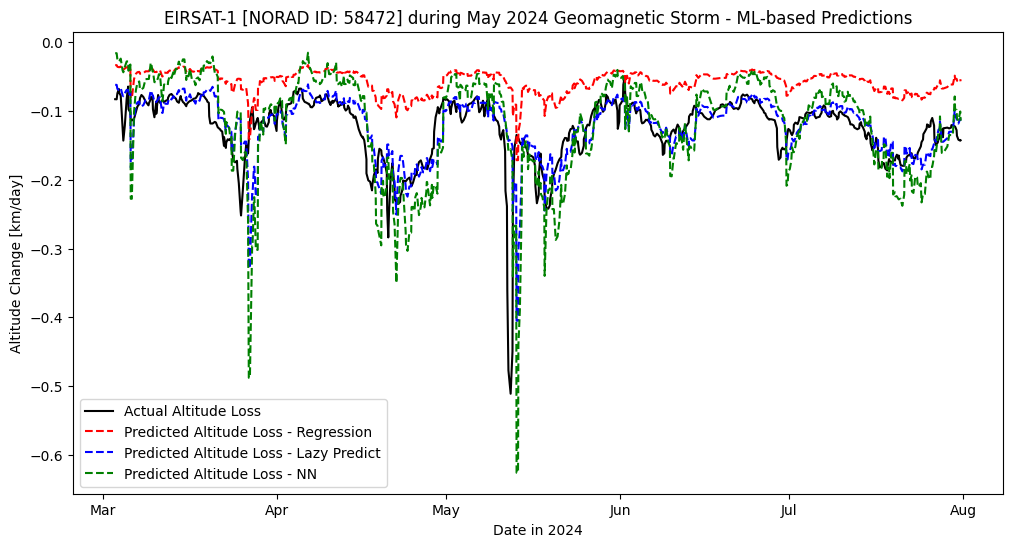

In [18]:
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
plt.xlabel("Date in 2024")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.title('EIRSAT-1 [NORAD ID: 58472] during May 2024 Geomagnetic Storm - ML-based Predictions')

plt.plot(time_sorted, y_test_sorted, label="Actual Altitude Loss", color="black", linestyle='-')
plt.plot(time_sorted, y_pred_sorted, label="Predicted Altitude Loss - Regression", color="red", linestyle='--')
plt.plot(time_sorted, y_pred_sorted_lp, label="Predicted Altitude Loss - Lazy Predict", color="blue", linestyle='--')
plt.plot(time_sorted, y_pred_sorted_nn, label="Predicted Altitude Loss - NN", color="green", linestyle='--')
plt.ylabel("Altitude Change [km/day]")

plt.legend()
plt.show()

## GOES-only Predictive Models (including LSTM)

In [19]:
# Step 1: Standardize and reshape data for LSTM input
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32).unsqueeze(1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).unsqueeze(1)

torch.manual_seed(14)

# Step 2: Define the LSTM-based regression model
class LSTMRegressor(nn.Module):
    def __init__(self, input_size, hidden_size=64, num_layers=1):
        super(LSTMRegressor, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 32)
        self.dropout = nn.Dropout(0.2)
        self.fc2 = nn.Linear(32, 1)

    def forward(self, x):
        _, (hn, _) = self.lstm(x)
        out = hn[-1]
        out = torch.relu(self.fc1(out))
        out = self.dropout(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]
model = LSTMRegressor(input_size=input_size)

# Step 3: Loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# Step 4: Train the model
epochs = 100
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.6f}")

# Step 5: Evaluate the model
model.eval()
with torch.no_grad():
    y_pred_tensor = model(X_test_tensor)
    y_pred_lstm = y_pred_tensor.numpy()

mse_lstm = mean_squared_error(y_test, y_pred_lstm)
r2_lstm = r2_score(y_test, y_pred_lstm)
print("LSTM Model - Mean Squared Error:", mse_lstm)
print("LSTM Model - R-squared:", r2_lstm)

# Step 6: Sort predictions and actual values for visualization
sorted_indices = testing_df['time_data'].argsort()
time_sorted = testing_df['time_data'].iloc[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted_lstm = y_pred_lstm[sorted_indices]

Epoch [10/100], Loss: 0.010752
Epoch [20/100], Loss: 0.002928
Epoch [30/100], Loss: 0.000733
Epoch [40/100], Loss: 0.001089
Epoch [50/100], Loss: 0.000680
Epoch [60/100], Loss: 0.000732
Epoch [70/100], Loss: 0.000702
Epoch [80/100], Loss: 0.000667
Epoch [90/100], Loss: 0.000587
Epoch [100/100], Loss: 0.000573
LSTM Model - Mean Squared Error: 0.006108692840120534
LSTM Model - R-squared: -1.7500719119431265


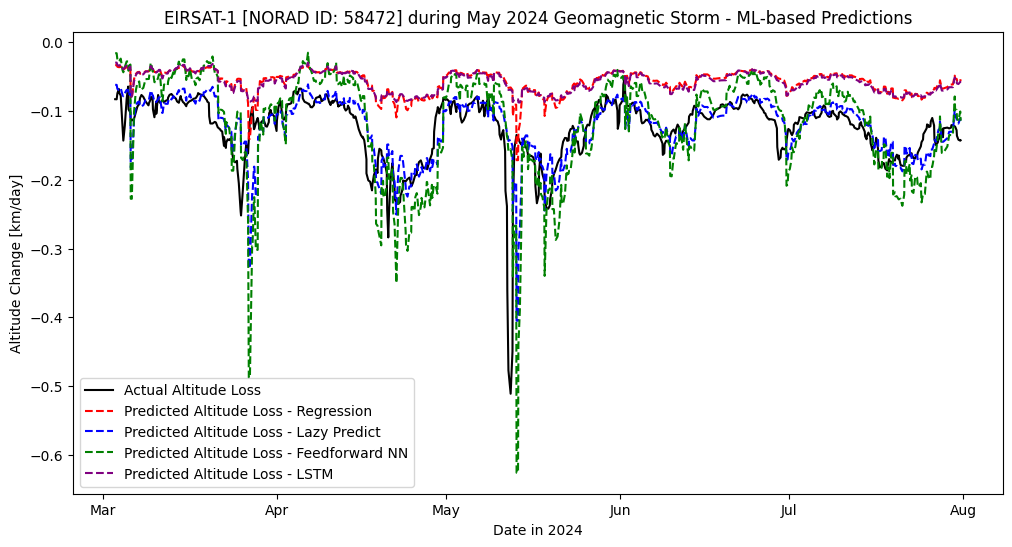

In [20]:
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
plt.xlabel("Date in 2024")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.title('EIRSAT-1 [NORAD ID: 58472] during May 2024 Geomagnetic Storm - ML-based Predictions')

plt.plot(time_sorted, y_test_sorted, label="Actual Altitude Loss", color="black", linestyle='-')
plt.plot(time_sorted, y_pred_sorted, label="Predicted Altitude Loss - Regression", color="red", linestyle='--')
plt.plot(time_sorted, y_pred_sorted_lp, label="Predicted Altitude Loss - Lazy Predict", color="blue", linestyle='--')
plt.plot(time_sorted, y_pred_sorted_nn, label="Predicted Altitude Loss - Feedforward NN", color="green", linestyle='--')
plt.plot(time_sorted, y_pred_sorted_lstm, label="Predicted Altitude Loss - LSTM", color="purple", linestyle='--')
plt.ylabel("Altitude Change [km/day]")

plt.legend()
plt.show()

## GOES + OMNIWeb Predictive Models

In [21]:
predictor_columns = ['alt_1day_lag', 'bc_1day_lag', 'xrsa_flux', 'xrsb_flux', 'omniweb__ae_index__[nT]', 'omniweb__al_index__[nT]', 'omniweb__au_index__[nT]', 'omniweb__sym_d__[nT]', 'omniweb__sym_h__[nT]', 'omniweb__asy_d__[nT]']
all_columns = ['time_data', 'deriv_alt_wrt_days', 'alt_1day_lag', 'bc_1day_lag', 'xrsa_flux', 'xrsb_flux', 'omniweb__ae_index__[nT]', 'omniweb__al_index__[nT]', 'omniweb__au_index__[nT]', 'omniweb__sym_d__[nT]', 'omniweb__sym_h__[nT]', 'omniweb__asy_d__[nT]']

training_df = training_data[all_columns].dropna()
testing_df = testing_data[all_columns].dropna()

X_train = training_df[predictor_columns]
y_train = training_df['deriv_alt_wrt_days']
X_test = testing_df[predictor_columns]
y_test = testing_df['deriv_alt_wrt_days']

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse)
print("R-squared:", r2)

# Sort predictions and actual values for visualization
sorted_indices = testing_df['time_data'].argsort()
time_sorted = testing_df['time_data'].iloc[sorted_indices]
y_test_sorted = y_test.iloc[sorted_indices]
y_pred_sorted = y_pred[sorted_indices]

Mean Squared Error: 0.006951538140681597
R-squared: -2.0528950236060575


In [22]:
lazypredict.Supervised.tqdm = tqdm
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 21%|██▏       | 9/42 [00:00<00:00, 53.60it/s]

GammaRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfGammaLoss'.


 62%|██████▏   | 26/42 [00:01<00:00, 28.15it/s]

PoissonRegressor model failed to execute
Some value(s) of y are out of the valid range of the loss 'HalfPoissonLoss'.


 90%|█████████ | 38/42 [00:02<00:00, 13.07it/s]

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000262 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1018
[LightGBM] [Info] Number of data points in the train set: 943, number of used features: 4
[LightGBM] [Info] Start training from score -0.005662


100%|██████████| 42/42 [00:03<00:00, 13.29it/s]

                               Adjusted R-Squared  R-Squared  RMSE  Time Taken
Model                                                                         
LinearSVR                                   -1.32      -1.26  0.07        0.02
HuberRegressor                              -1.61      -1.54  0.08        0.01
SGDRegressor                                -2.01      -1.93  0.08        0.00
OrthogonalMatchingPursuitCV                 -2.10      -2.01  0.08        0.00
RidgeCV                                     -2.11      -2.03  0.08        0.00
BayesianRidge                               -2.13      -2.04  0.08        0.00
Ridge                                       -2.13      -2.05  0.08        0.00
ElasticNetCV                                -2.13      -2.05  0.08        0.02
LassoCV                                     -2.13      -2.05  0.08        0.02
LarsCV                                      -2.14      -2.05  0.08        0.01
LassoLarsCV                                 -2.14   

In [23]:
# Train the RANSAC model
model2 = sklearn.linear_model.RANSACRegressor(random_state=6)
model2.fit(X_train, y_train)

# Predict on the test set
y_pred_lp = model2.predict(X_test)

# Evaluate the model
mse_lp = mean_squared_error(y_test, y_pred_lp)
r2_lp = r2_score(y_test, y_pred_lp)
print("Mean Squared Error:", mse_lp)
print("R-squared:", r2_lp)

# Sort predictions and actual values for visualization
sorted_indices_lp = testing_df['time_data'].argsort()
time_sorte_lp = testing_df['time_data'].iloc[sorted_indices]
y_test_sorted_lp = y_test.iloc[sorted_indices]
y_pred_sorted_lp = y_pred_lp[sorted_indices]

Mean Squared Error: 0.0021211948742598835
R-squared: 0.0684385031523791


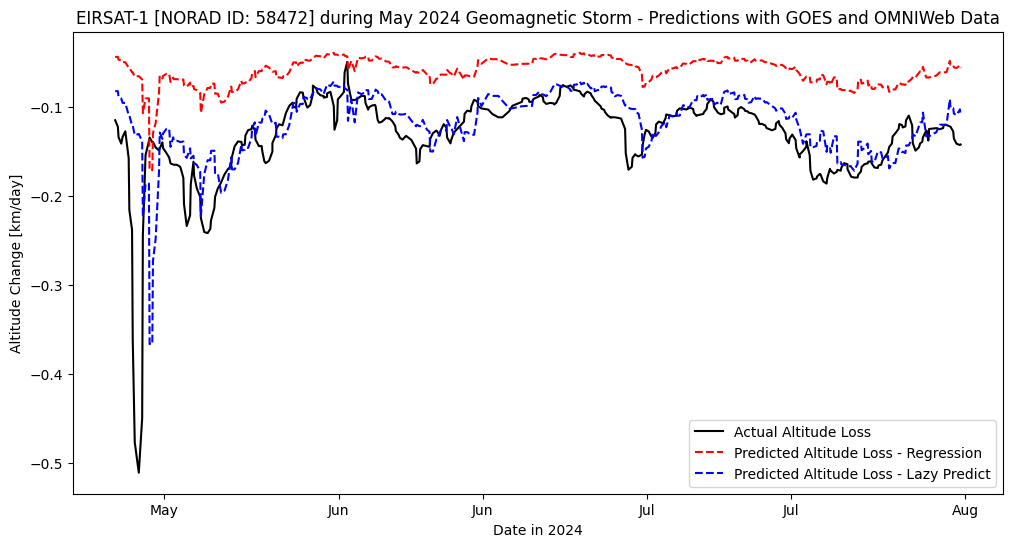

In [24]:
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
plt.xlabel("Date in 2024")
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b"))
plt.title('EIRSAT-1 [NORAD ID: 58472] during May 2024 Geomagnetic Storm - Predictions with GOES and OMNIWeb Data')

plt.plot(time_sorted, y_test_sorted, label="Actual Altitude Loss", color="black", linestyle='-')
plt.plot(time_sorted, y_pred_sorted, label="Predicted Altitude Loss - Regression", color="red", linestyle='--')
plt.plot(time_sorted, y_pred_sorted_lp, label="Predicted Altitude Loss - Lazy Predict", color="blue", linestyle='--')
plt.ylabel("Altitude Change [km/day]")

plt.legend()
plt.show()